<a href="https://colab.research.google.com/github/nazmulhasan77/Gene-Expression-RNAseq/blob/main/rnaseq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNA-seq Data Processing Pipeline Documentation

## Overview
This pipeline processes raw RNA-seq count data from GEO datasets, performing quality control, normalization, and transformation for downstream analysis.

### Purpose
Process raw RNA-seq count data through cleaning, filtering, and normalization steps.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('GSE154881_raw_counts_GRCh38.p13_NCBI.tsv', sep='\\t', index_col=0)

print("Data shape:", df.shape)
print("\\nFirst few rows:")
print(df.head())
print("\\nColumn names:")
print(df.columns.tolist())


/tmp/ipython-input-2793674079.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('GSE154881_raw_counts_GRCh38.p13_NCBI.tsv', sep='\\t', index_col=0)


Data shape: (39376, 14)
\nFirst few rows:
           GSM4681806  GSM4681807  GSM4681808  GSM4681809  GSM4681810  \
GeneID                                                                  
100287102          12          28          59          32          79   
653635            455         215         119         117         106   
102466751           7           3           0           1           1   
107985730           0           0           0           0           0   
100302278           0           0           0           0           0   

           GSM4681811  GSM4681812  GSM4681813  GSM4681814  GSM4681815  \
GeneID                                                                  
100287102          46          17          28          27           6   
653635            400         294         172         259         392   
102466751           0           1           1           1           6   
107985730           0           1           0           0           0   
10030227

Step 2: Data Cleaning and Preprocessing

In [3]:
# Remove version numbers from gene IDs if present

# Check for missing values
print("Missing values:", df.isnull().sum().sum())

# Remove genes with zero counts across all samples
df = df[(df > 0).any(axis=1)]
print("Shape after removing zero-count genes:", df.shape)

# Basic statistics
print("\\nSummary statistics:")
print(df.describe())


Missing values: 0
Shape after removing zero-count genes: (26770, 14)
\nSummary statistics:
         GSM4681806    GSM4681807    GSM4681808    GSM4681809    GSM4681810  \
count  2.677000e+04  2.677000e+04  2.677000e+04  2.677000e+04  2.677000e+04   
mean   7.497862e+02  7.937251e+02  9.842174e+02  9.055604e+02  8.258315e+02   
std    2.303796e+04  4.156683e+04  6.411197e+04  7.132519e+04  5.976140e+04   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    2.200000e+01  1.200000e+01  2.000000e+00  1.000000e+00  6.000000e+00   
75%    2.390000e+02  1.270000e+02  3.700000e+01  1.800000e+01  6.600000e+01   
max    2.229077e+06  4.865021e+06  7.694712e+06  9.418419e+06  7.758087e+06   

         GSM4681811    GSM4681812    GSM4681813    GSM4681814    GSM4681815  \
count  2.677000e+04  2.677000e+04  2.677000e+04  2.677000e+04  2.677000e+04   
mean   7.094197e+02  8.614562e+02  6.64

Step 3: Quality Control and Normalization

In [4]:
# Calculate library sizes
library_sizes = df.sum(axis=0)
print("Library sizes:")
print(library_sizes)

# Normalize using Counts Per Million (CPM)
def cpm_normalization(counts):
    return (counts / counts.sum(axis=0)) * 1e6

df_cpm = cpm_normalization(df)

# Log2 transformation for downstream analysis
df_log2 = np.log2(df_cpm + 1)  # Add pseudocount to avoid log(0)


Library sizes:
GSM4681806    20071776
GSM4681807    21248021
GSM4681808    26347501
GSM4681809    24241852
GSM4681810    22107510
GSM4681811    18991165
GSM4681812    23061182
GSM4681813    17789206
GSM4681814    19316176
GSM4681815    18866556
GSM4681816    19911451
GSM4681817    19036090
GSM4681818    22158760
GSM4681820    18000913
dtype: int64


Step 4: Exploratory Data Analysis

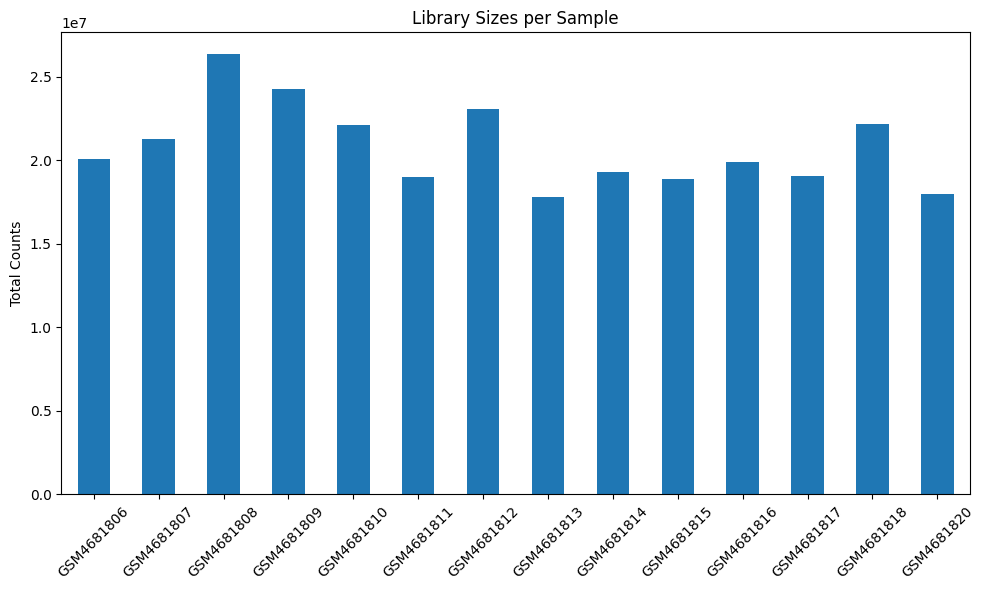

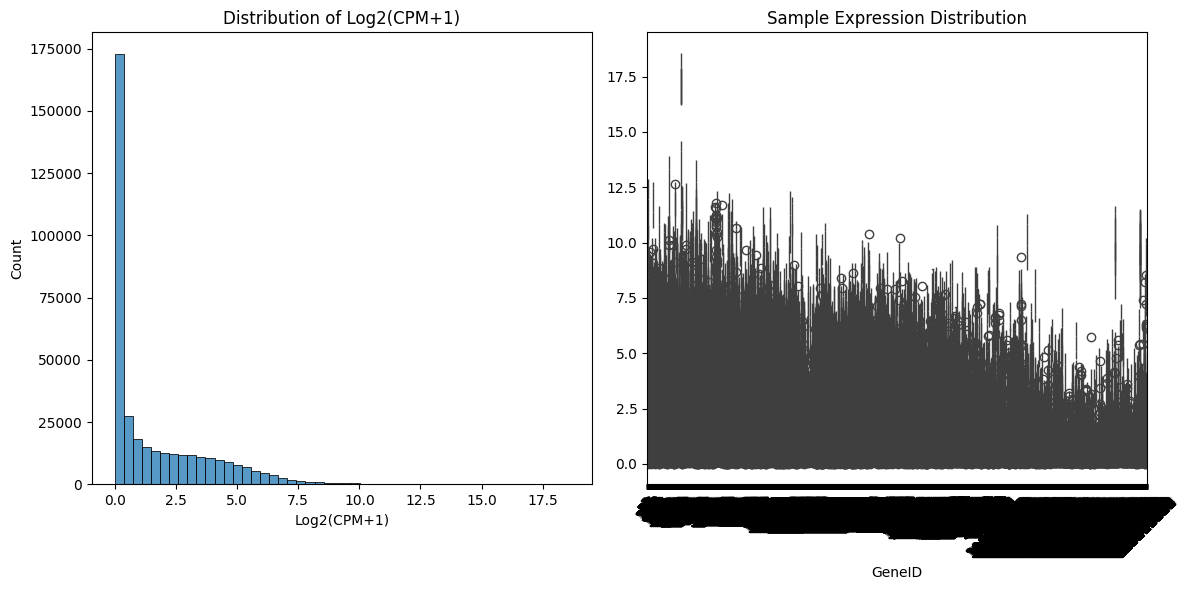

In [2]:
# Plot library sizes
plt.figure(figsize=(10, 6))
library_sizes.plot(kind='bar')
plt.title('Library Sizes per Sample')
plt.ylabel('Total Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribution of gene expression
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_log2.values.flatten(), bins=50)
plt.title('Distribution of Log2(CPM+1)')
plt.xlabel('Log2(CPM+1)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_log2.T)
plt.title('Sample Expression Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Step 5: Sample Correlation Analysis

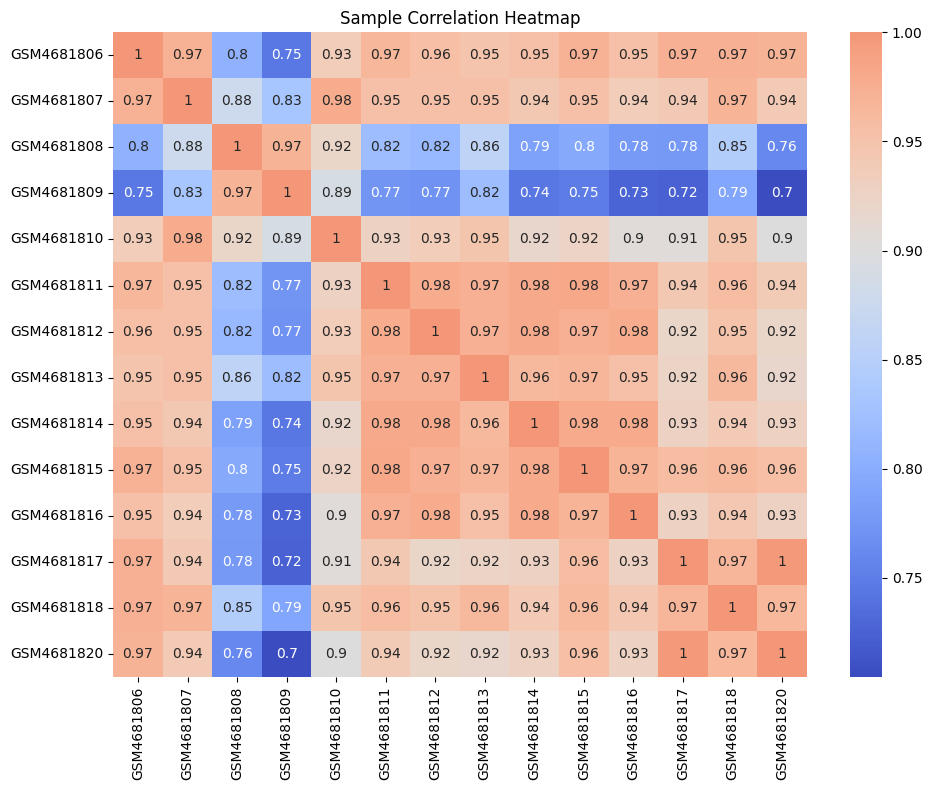

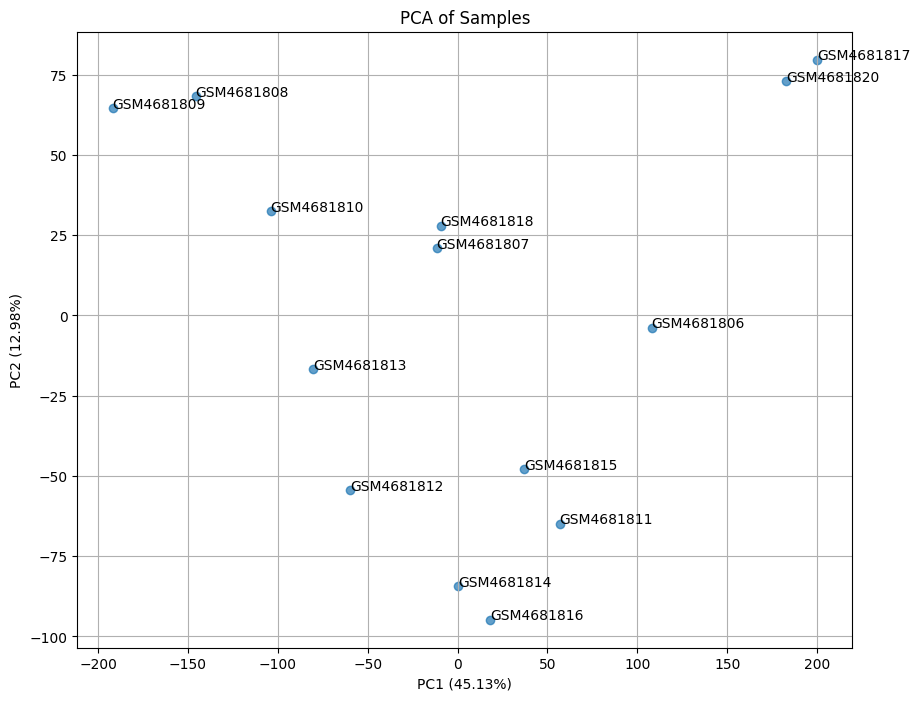

In [6]:
# Calculate correlation matrix
correlation_matrix = df_log2.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0.9)
plt.title('Sample Correlation Heatmap')
plt.tight_layout()
plt.show()

# PCA for sample clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_log2.T)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Plot PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
for i, sample in enumerate(df_log2.columns):
    plt.annotate(sample, (pca_result[i, 0], pca_result[i, 1]))
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA of Samples')
plt.grid(True)
plt.show()


Step 6: Highly Variable Genes Identification

Top 10 most variable genes:
Index([3576, 6192, 7503, 8653, 50486, 5328, 414062, 7128, 2352, 4869], dtype='int64', name='GeneID')


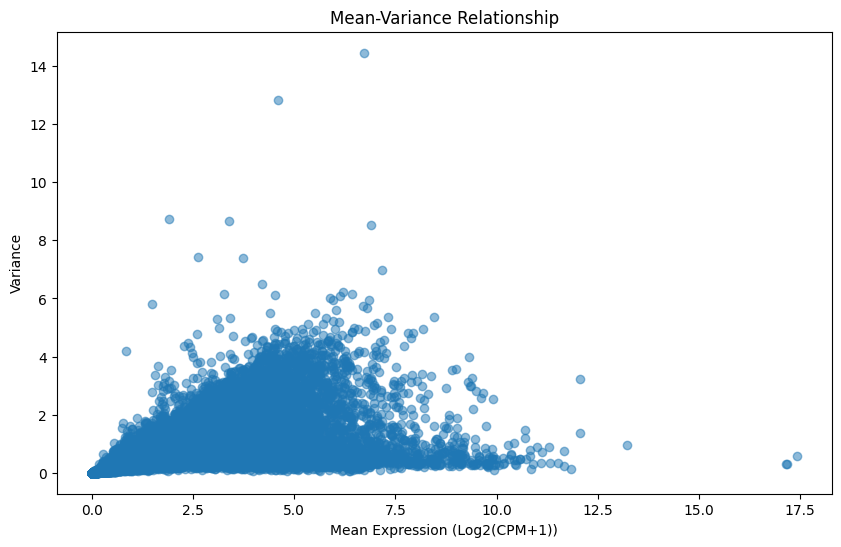

In [7]:
# Calculate mean and variance
mean_expression = df_log2.mean(axis=1)
variance_expression = df_log2.var(axis=1)

# Identify top variable genes
top_variable_genes = variance_expression.nlargest(50).index
print("Top 10 most variable genes:")
print(top_variable_genes[:10])

# Plot mean-variance relationship
plt.figure(figsize=(10, 6))
plt.scatter(mean_expression, variance_expression, alpha=0.5)
plt.xlabel('Mean Expression (Log2(CPM+1))')
plt.ylabel('Variance')
plt.title('Mean-Variance Relationship')
plt.show()


Step 7: Save Processed Data

In [6]:
# Save processed data
df_log2.to_csv('GSE154881_processed_log2cpm.csv')
df_cpm.to_csv('GSE154881_processed_cpm.csv')

# Save metadata about processing
processing_info = {
    'original_shape': df.shape,
    'processed_shape': df_log2.shape,
    'genes_removed': df.shape[0] - df_log2.shape[0],
    'normalization_method': 'CPM + Log2',
    'pseudocount': 1
}

import json
with open('processing_metadata.json', 'w') as f:
    json.dump(processing_info, f, indent=4)


Complete Analysis Script

In [5]:

def process_rna_seq_data(file_path):
    """
    Robust pipeline for processing RNA-seq count data
    """
    try:
        # Load data
        df = pd.read_csv(file_path, sep='\t', index_col=0)
        print(f"✓ Loaded data: {df.shape[0]:,} genes × {df.shape[1]} samples")

        # Check index type and convert to string if needed
        if not pd.api.types.is_string_dtype(df.index):
            df.index = df.index.astype(str)
            print("✓ Converted index to string")

        # Optional: Clean gene IDs (remove version numbers)
        try:
            if df.index.str.contains('\.', regex=True).any():
                original_count = len(df)
                df.index = df.index.str.split('\.').str[0]
                print(f"✓ Cleaned gene IDs (removed version numbers)")
        except:
            print("⚠ Could not clean gene IDs, proceeding without cleaning")

        # Remove zero-count genes
        non_zero_mask = (df > 0).any(axis=1)
        df = df[non_zero_mask]
        print(f"✓ Removed zero-count genes: {df.shape[0]:,} genes remaining")

        # Normalize
        print("Normalizing data...")
        df_cpm = (df / df.sum(axis=0)) * 1e6
        df_log2 = np.log2(df_cpm + 1)

        print("✓ Normalization complete")
        return df, df_cpm, df_log2

    except Exception as e:
        print(f"❌ Error in processing: {e}")
        raise

# Run the analysis
try:
    raw_df, cpm_df, log2_df = process_rna_seq_data('GSE154881_raw_counts_GRCh38.p13_NCBI.tsv')

    # Save results
    import os
    os.makedirs('results', exist_ok=True)

    raw_df.to_csv('results/filtered_raw_counts.csv')
    cpm_df.to_csv('results/normalized_cpm.csv')
    log2_df.to_csv('results/log2_transformed.csv')

    print("✓ All files saved successfully!")

except Exception as e:
    print(f"Final error: {e}")

<>:17: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:17: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-4079532283.py:17: SyntaxWarning: invalid escape sequence '\.'
  if df.index.str.contains('\.', regex=True).any():
/tmp/ipython-input-4079532283.py:19: SyntaxWarning: invalid escape sequence '\.'
  df.index = df.index.str.split('\.').str[0]


✓ Loaded data: 39,376 genes × 14 samples
✓ Converted index to string
✓ Removed zero-count genes: 26,770 genes remaining
Normalizing data...
✓ Normalization complete
✓ All files saved successfully!


TSV file already exists.
Loading data...
Data shape: (39376, 14)
Columns: ['GSM4681806', 'GSM4681807', 'GSM4681808', 'GSM4681809', 'GSM4681810', 'GSM4681811', 'GSM4681812', 'GSM4681813', 'GSM4681814', 'GSM4681815', 'GSM4681816', 'GSM4681817', 'GSM4681818', 'GSM4681820']

First 5 rows:
           GSM4681806  GSM4681807  GSM4681808  GSM4681809  GSM4681810  \
GeneID                                                                  
100287102          12          28          59          32          79   
653635            455         215         119         117         106   
102466751           7           3           0           1           1   
107985730           0           0           0           0           0   
100302278           0           0           0           0           0   

           GSM4681811  GSM4681812  GSM4681813  GSM4681814  GSM4681815  \
GeneID                                                                  
100287102          46          17          28          2

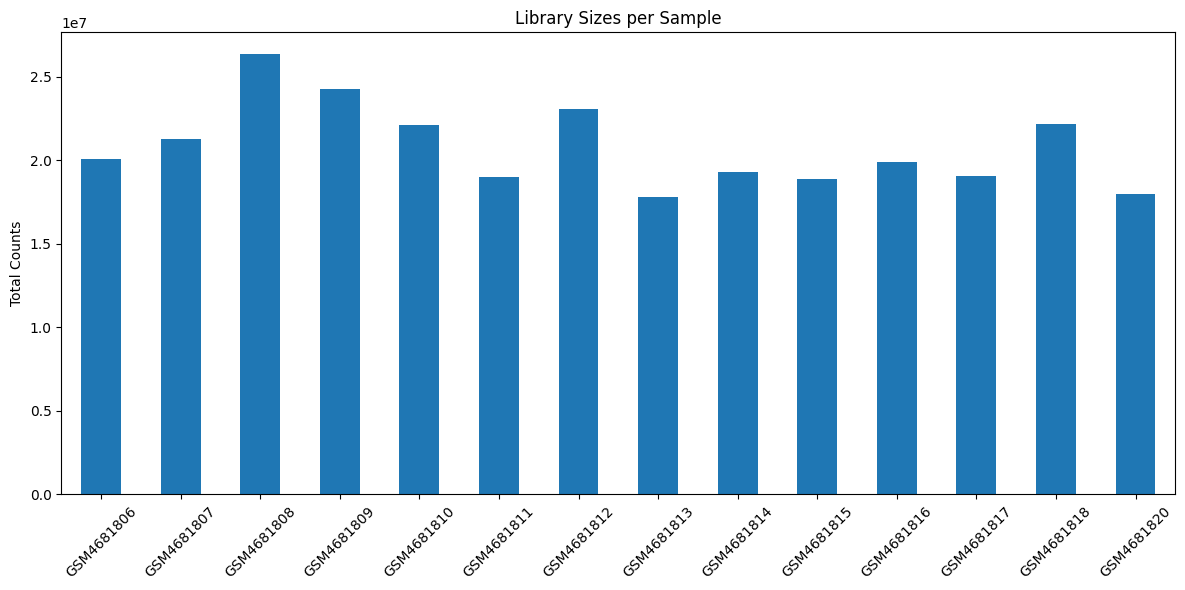

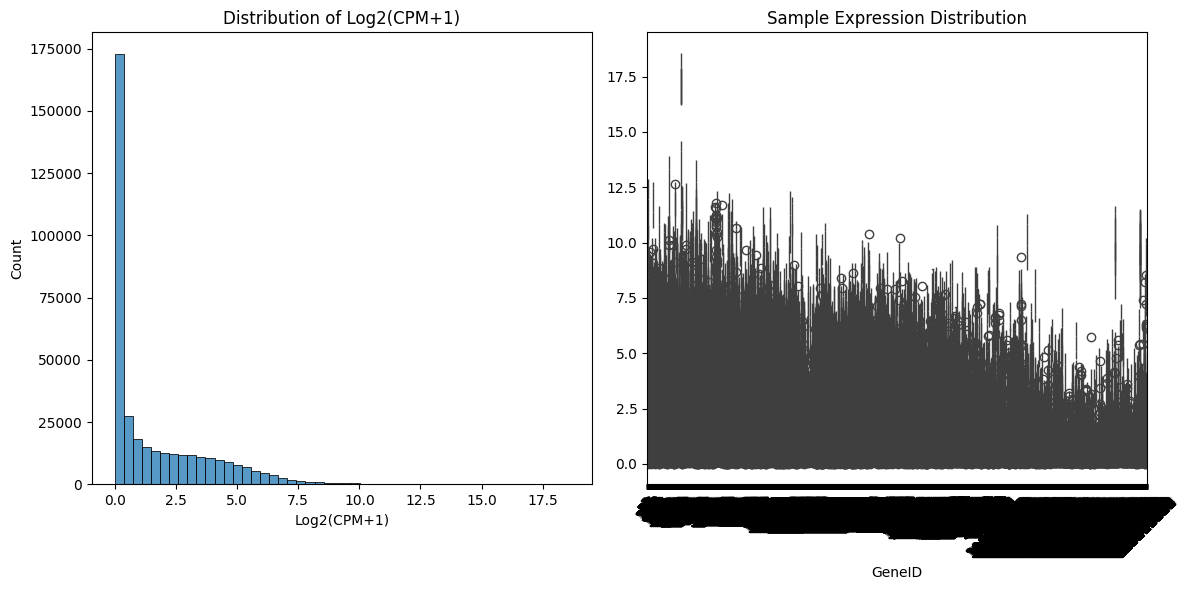

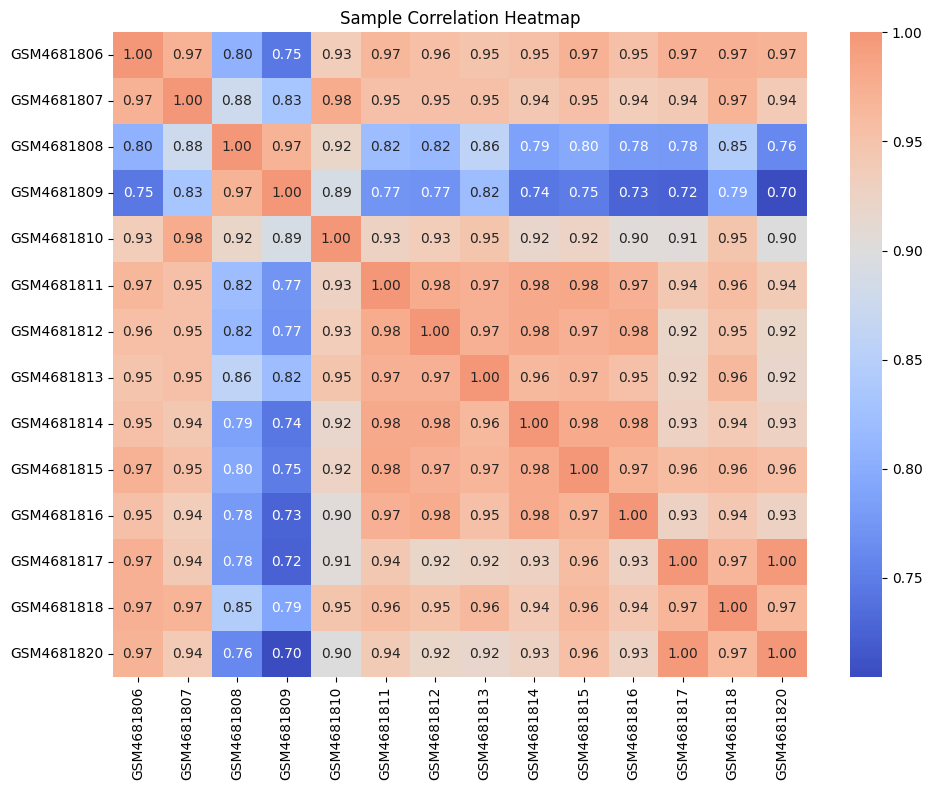

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import shutil

# First, let's check if we need to decompress or if it's already done
import os

def decompress_file():
    """Decompress the gzipped file if needed"""
    gz_file = 'GSE154881_raw_counts_GRCh38.p13_NCBI.tsv_2.gz'
    tsv_file = 'GSE154881_raw_counts_GRCh38.p13_NCBI.tsv'

    if os.path.exists(gz_file) and not os.path.exists(tsv_file):
        print("Decompressing file...")
        with gzip.open(gz_file, 'rb') as f_in:
            with open(tsv_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print("File decompressed successfully!")
    elif os.path.exists(tsv_file):
        print("TSV file already exists.")
    else:
        print("No files found. Please check the filename.")
        return False
    return True

# Decompress the file
if decompress_file():
    # Load the data
    print("Loading data...")
    df = pd.read_csv('GSE154881_raw_counts_GRCh38.p13_NCBI.tsv', sep='\t', index_col=0)

    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst 5 rows:")
    print(df.head())

    # Basic data info
    print("\n=== DATA INFORMATION ===")
    print(f"Total genes: {df.shape[0]}")
    print(f"Total samples: {df.shape[1]}")
    print(f"Total counts: {df.sum().sum():,}")
    print(f"Missing values: {df.isnull().sum().sum()}")

    # Check for zero-count genes
    zero_count_genes = (df == 0).all(axis=1).sum()
    print(f"Genes with zero counts in all samples: {zero_count_genes}")

    # Remove genes with zero counts across all samples
    df = df[(df > 0).any(axis=1)]
    print(f"Shape after removing zero-count genes: {df.shape}")

    # Calculate library sizes
    library_sizes = df.sum(axis=0)
    print("\n=== LIBRARY SIZES ===")
    print(library_sizes)

    # Normalize using CPM
    print("\nNormalizing data...")
    df_cpm = (df / df.sum(axis=0)) * 1e6
    df_log2 = np.log2(df_cpm + 1)  # Add pseudocount

    # Create output directory
    os.makedirs('results', exist_ok=True)

    # Save processed data
    df_log2.to_csv('results/processed_log2cpm.csv')
    df_cpm.to_csv('results/processed_cpm.csv')
    df.to_csv('results/filtered_raw_counts.csv')

    print("\n=== PROCESSING COMPLETE ===")
    print("Saved files:")
    print("- results/processed_log2cpm.csv")
    print("- results/processed_cpm.csv")
    print("- results/filtered_raw_counts.csv")

    # Generate basic plots
    print("\nGenerating basic plots...")

    # Library sizes plot
    plt.figure(figsize=(12, 6))
    library_sizes.plot(kind='bar')
    plt.title('Library Sizes per Sample')
    plt.ylabel('Total Counts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/library_sizes.png', dpi=300, bbox_inches='tight')

    # Expression distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_log2.values.flatten(), bins=50)
    plt.title('Distribution of Log2(CPM+1)')
    plt.xlabel('Log2(CPM+1)')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_log2.T)
    plt.title('Sample Expression Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/expression_distribution.png', dpi=300, bbox_inches='tight')

    # Sample correlation
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_log2.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0.9, fmt='.2f')
    plt.title('Sample Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('results/sample_correlation.png', dpi=300, bbox_inches='tight')

    print("Plots saved in 'results' directory!")

else:
    print("Please check that the file exists in the current directory.")